In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

data = pd.read_excel('EPOC dataset.xlsx')

columns = ['metal','support','wt.%','ionic species','particle size(nm)','metal loading (mg)','CO2:H2 ratio','temp(℃)','rCO(mol/s)',
          'voltage(V)','ρCO','ΛCO']
data = data[columns]

# change string in data['metal'] into int with metal's atomic mass
data['metal'] = data['metal'].replace(['Fe','Co','Ni','Cu','ZnO','Ru','Rh','Pd','Pt'],
                                      ['55.8','58.9','58.7','63.5','65.4','101.1','102.9','106.4','195.1']).astype(float)

# change string in data['wt.%'] into int, where 100: no support
data['wt.%'] = data['wt.%'].fillna(100).astype(float)


# change string in data['CO2:H2 ratio'] into int by calculating the ratios
data['gas ratio'] = data['CO2:H2 ratio'].apply(lambda x: int(x.split(':')[0]) / int(x.split(':')[1]))

# delete the data['CO2:H ratio'] column, which has been converted into data['gas ratio']
data = data.drop('CO2:H2 ratio', axis=1)

# change the columns' names into abbreviations, where M:metal, S:support, WT.%:wt.%, IS:ionic species, PS:particle size,
# ML:metal loading, T: temperature, RR:reaction rate, V:applied potential, ρ:enhancement ratio, Λ:Faradaic efficiency, GR:gas ratio
data.columns = ['M','S','WT','IS','PS','L','T','RR','V','ρ','Λ','GR']

#determine the ionic charge
ionic_charge = {
    'O2-': -2,
    'H+': 1,
    'Li+': 1,
    'Na+': 1,
    'K+': 1,
    'none': 0
}
data['IS_charge'] = data['IS'].replace(ionic_charge).fillna(0).astype(float)

# define a function to make a classification for EPOC behavior based on the applied potential and ρ values
# 0: electrophobic, 1: electrophilic
def electro_class(row):
    if row['V'] > 0 and row['ρ'] >= 1:
        return 0
    elif row['V'] < 0 and row['ρ'] >= 1:
        return 1
    elif row['V'] > 0 and row['ρ'] <= 1:
        return 1
    elif row['V'] < 0 and row['ρ'] <= 1:
        return 0
    else:
        return 'undefined'

# create a new column named 'BH' (EPOC behavior)
data['BH'] = data.apply(electro_class, axis=1)


# determine the columns that are used as features in classification
features = ['M', 'L', 'V', 'T', 'GR']

X = data[features].copy()
y = data['ρ']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=0)

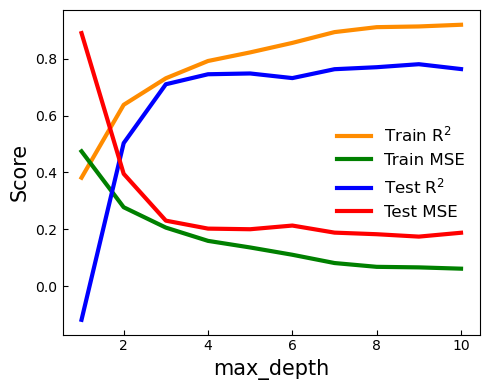

In [8]:
# plot r2 score and mse vs. max_depth
train_sc_all=[]
test_sc_all=[]
test_mse_all=[]
train_mse_all=[]
depth_range=range(1,11)
for i in depth_range:
    RFR = RandomForestRegressor(n_estimators=10, max_depth=i, min_samples_split=2, random_state=0)
    RFR.fit(X_train, y_train)
    y_predict = RFR.predict(X_test)
    y_predict_2 = RFR.predict(X_train)
    train_sc = RFR.score(X_train, y_train)
    test_sc = RFR.score(X_test, y_test)
    mse_test = mean_squared_error(y_test, y_predict)
    mse_train = mean_squared_error(y_train, y_predict_2)
    train_sc_all.append(train_sc)
    test_sc_all.append(test_sc)
    test_mse_all.append(mse_test)
    train_mse_all.append(mse_train)
plt.figure(figsize=(5,4))
plt.plot(depth_range, train_sc_all, lw=3, c='darkorange', label='Train R$^{2}$')
plt.plot(depth_range, train_mse_all, lw=3, c='green', label='Train MSE')
plt.plot(depth_range, test_sc_all, lw=3, c='blue', label='Test R$^{2}$')
plt.plot(depth_range, test_mse_all, lw=3, c='red', label='Test MSE')
plt.xlabel('max_depth', fontsize=15)
plt.ylabel('Score', fontsize=15)
plt.legend(loc='best', fontsize=12, frameon=False)
plt.tick_params(which='both', direction='in', labelsize=10)
plt.tight_layout()
plt.savefig('RFR Scores vs. max_depth.jpg', format='jpeg', dpi=600)
plt.show()

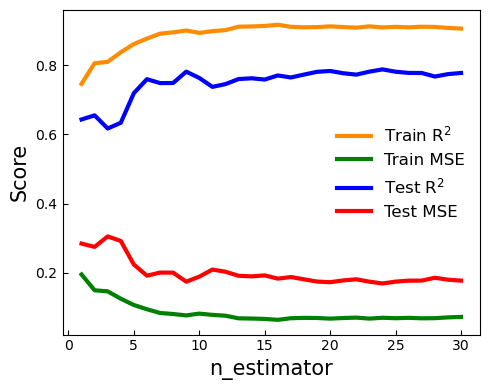

In [3]:
# plot r2 score and mse vs. n_estimator
train_sc_all=[]
test_sc_all=[]
test_mse_all=[]
train_mse_all=[]
estimator_range=range(1,31)
for i in estimator_range:
    RFR = RandomForestRegressor(n_estimators=i, max_depth=7, min_samples_split=2, random_state=0)
    RFR.fit(X_train, y_train)
    y_predict = RFR.predict(X_test)
    y_predict_2 = RFR.predict(X_train)
    train_sc = RFR.score(X_train, y_train)
    test_sc = RFR.score(X_test, y_test)
    mse_test = mean_squared_error(y_test, y_predict)
    mse_train = mean_squared_error(y_train, y_predict_2)
    train_sc_all.append(train_sc)
    test_sc_all.append(test_sc)
    test_mse_all.append(mse_test)
    train_mse_all.append(mse_train)
plt.figure(figsize=(5,4))
plt.plot(estimator_range, train_sc_all, lw=3, c='darkorange', label='Train R$^{2}$')
plt.plot(estimator_range, train_mse_all, lw=3, c='green', label='Train MSE')
plt.plot(estimator_range, test_sc_all, lw=3, c='blue', label='Test R$^{2}$')
plt.plot(estimator_range, test_mse_all, lw=3, c='red', label='Test MSE')
plt.xlabel('n_estimator', fontsize=15)
plt.ylabel('Score', fontsize=15)
plt.legend(loc='best', fontsize=12, frameon=False)
plt.tick_params(which='both', direction='in', labelsize=10)
plt.tight_layout()
plt.savefig('RFR Scores vs. n_estimator.jpg', format='jpeg', dpi=600)
plt.show()

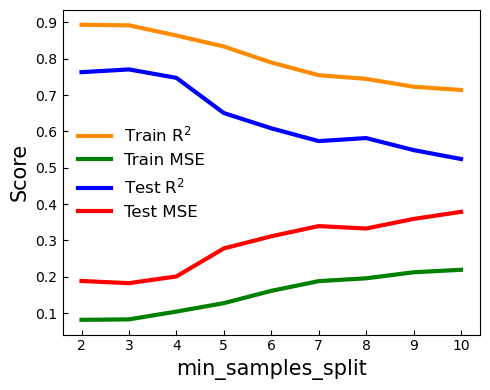

In [9]:
# plot r2 score and mse vs. min_samples_split
train_sc_all=[]
test_sc_all=[]
test_mse_all=[]
train_mse_all=[]
split_range=range(2,11)
for i in split_range:
    RFR = RandomForestRegressor(n_estimators=10, max_depth=7, min_samples_split=i, random_state=0)
    RFR.fit(X_train, y_train)
    y_predict = RFR.predict(X_test)
    y_predict_2 = RFR.predict(X_train)
    train_sc = RFR.score(X_train, y_train)
    test_sc = RFR.score(X_test, y_test)
    mse_test = mean_squared_error(y_test, y_predict)
    mse_train = mean_squared_error(y_train, y_predict_2)
    train_sc_all.append(train_sc)
    test_sc_all.append(test_sc)
    test_mse_all.append(mse_test)
    train_mse_all.append(mse_train)
plt.figure(figsize=(5,4))
plt.plot(split_range, train_sc_all, lw=3, c='darkorange', label='Train R$^{2}$')
plt.plot(split_range, train_mse_all, lw=3, c='green', label='Train MSE')
plt.plot(split_range, test_sc_all, lw=3, c='blue', label='Test R$^{2}$')
plt.plot(split_range, test_mse_all, lw=3, c='red', label='Test MSE')
plt.xlabel('min_samples_split', fontsize=15)
plt.ylabel('Score', fontsize=15)
plt.legend(loc='best', fontsize=12, frameon=False)
plt.tick_params(which='both', direction='in', labelsize=10)
plt.tight_layout()
plt.savefig('RFR Scores vs. min_samples_split.jpg', format='jpeg', dpi=600)
plt.show()

[0.7607090214112314, 0.7920861738542543, 0.8077183921045961, 0.7916221014711442, 0.8223552063289183, 0.8400554595672839, 0.8370319297106226, 0.8557472697881796, 0.8816810811721033, 0.8612843881392676, 0.8936802317110298, 0.9137190021300488]
[0.6456143448056868, 0.7454638857789271, 0.7383906491259935, 0.6758647663742827, 0.7482135394566389, 0.7391809034425219, 0.6815576165025321, 0.7319628066112829, 0.728656358444667, 0.7193411110825669, 0.7632060233842632, 0.7585922233536574]
[0.18361809910697957, 0.15954108157394922, 0.14754581866482797, 0.15989718396166677, 0.13631437140884597, 0.12273221769578752, 0.12505230016670857, 0.11069122734462188, 0.09079111586946854, 0.1064423620002062, 0.08158365963417703, 0.0662070626789497]
[0.282126312009337, 0.2026361228955608, 0.20826712443755954, 0.25804396062523216, 0.2004471244414038, 0.2076380032172061, 0.25351188437450406, 0.21338432790297007, 0.21601659027991607, 0.22343245586364865, 0.18851161255946636, 0.19218465735658063]


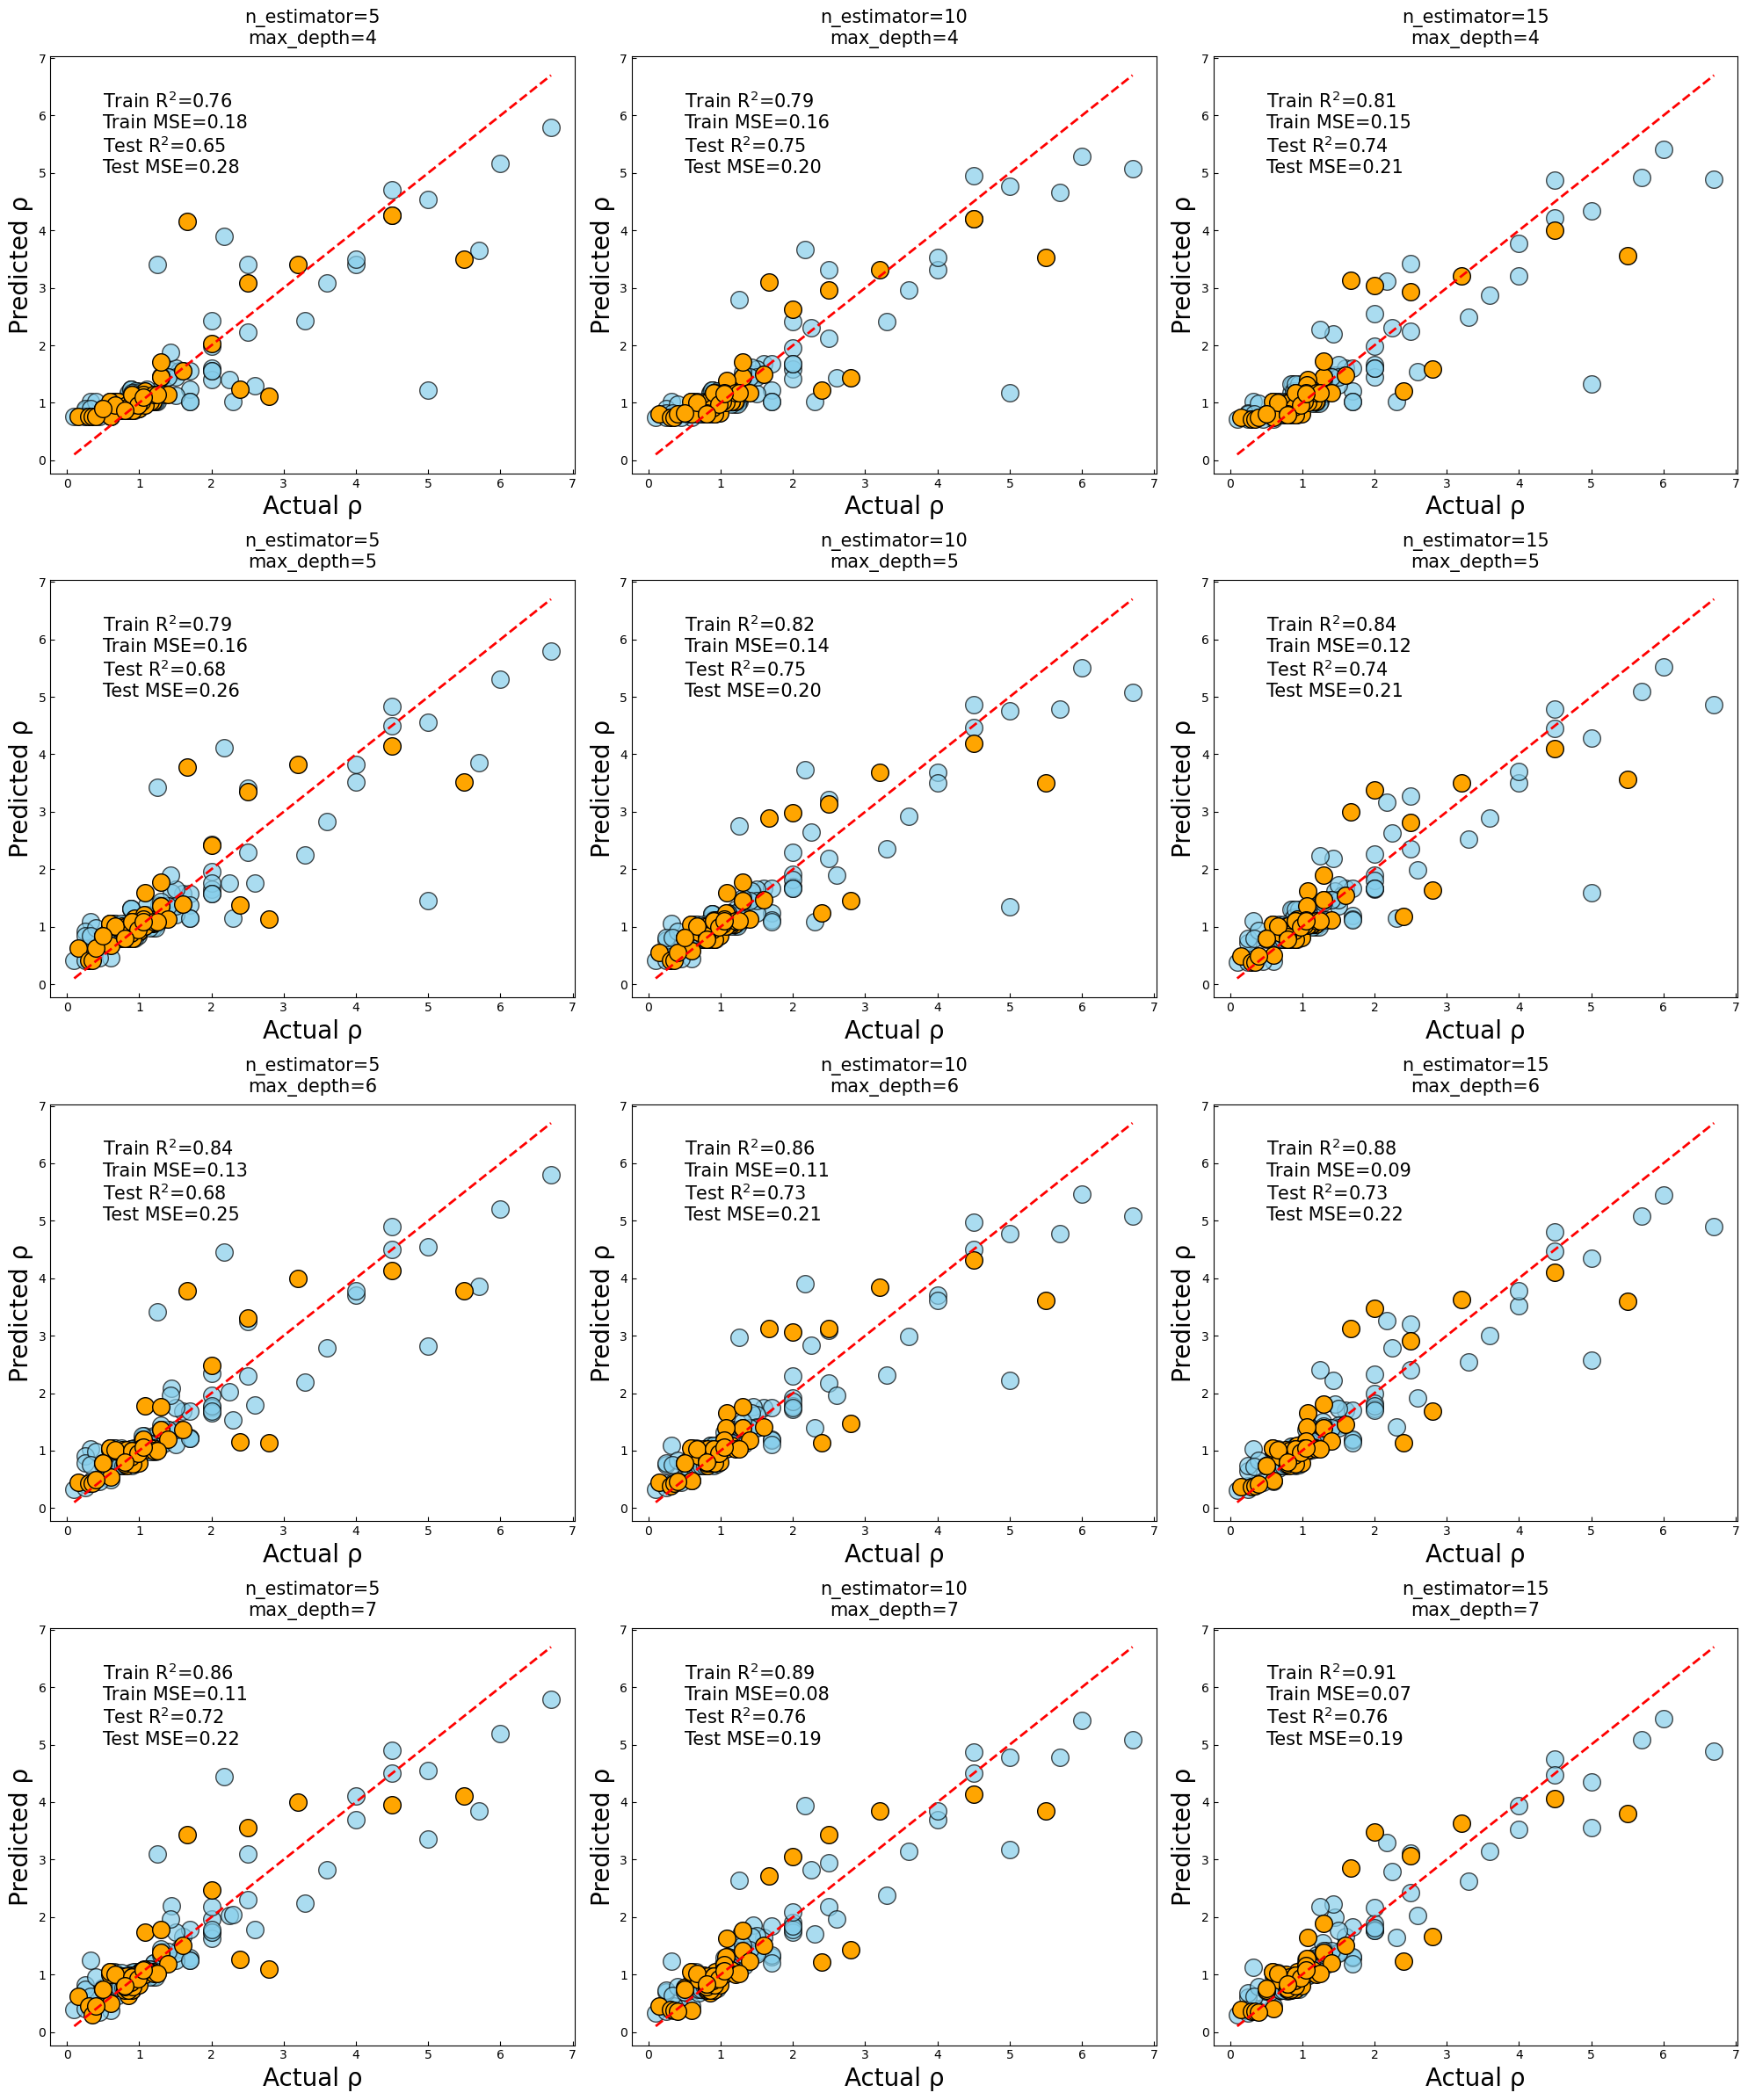

In [10]:
from sklearn.model_selection import cross_val_score

n = [5, 10, 15]
m = [4, 5, 6, 7]

fig, subaxes = plt.subplots(len(m), len(n), figsize=(len(m)*5, len(n)*8))

all_train_r2 = []
all_test_r2 = []
all_train_mse = []
all_test_mse = []

for i, this_m in enumerate(m):
    for j, this_n in enumerate(n):
        RFR = RandomForestRegressor(n_estimators=this_n, max_depth=this_m, min_samples_split=2, random_state=0)
        RFR.fit(X_train, y_train)
        y_predict = RFR.predict(X_test)
        y_predict_2 = RFR.predict(X_train)

        subaxes[i, j].scatter(y_train, y_predict_2, s=200, alpha=0.7, edgecolors='black', c='skyblue')
        subaxes[i, j].scatter(y_test, y_predict, s=200, edgecolors='black', c='orange')
        subaxes[i, j].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
        subaxes[i, j].set_title(f'n_estimator={this_n}\nmax_depth={this_m}', pad=10, fontsize=15)
        subaxes[i, j].set_xlabel('Actual ρ', size=20)
        subaxes[i, j].set_ylabel('Predicted ρ', size=20)

        train_sc = RFR.score(X_train, y_train)
        test_sc = RFR.score(X_test, y_test)
        train_mse = mean_squared_error(y_train, y_predict_2)
        test_mse = mean_squared_error(y_test, y_predict)
        all_train_r2.append(train_sc)
        all_test_r2.append(test_sc)
        all_train_mse.append(train_mse)
        all_test_mse.append(test_mse)
        
        subaxes[i, j].text(0.5, 5, f'Train R$^{2}$={train_sc:.2f}\nTrain MSE={train_mse:.2f}\nTest R$^{2}$={test_sc:.2f}\nTest MSE={test_mse:.2f}',
                             fontsize=15)
        subaxes[i, j].tick_params(which='both', direction='in', labelsize=10)

print(all_train_r2)
print(all_test_r2)
print(all_train_mse)
print(all_test_mse)

plt.tight_layout()
plt.savefig('RFR prediction matrix.jpg', format='jpeg', dpi=600)
plt.show()

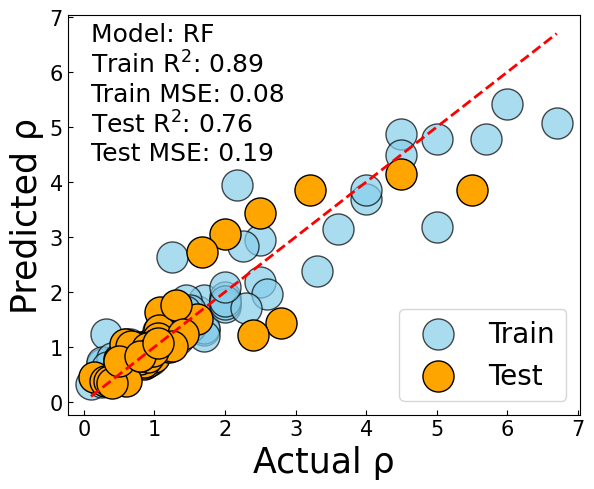

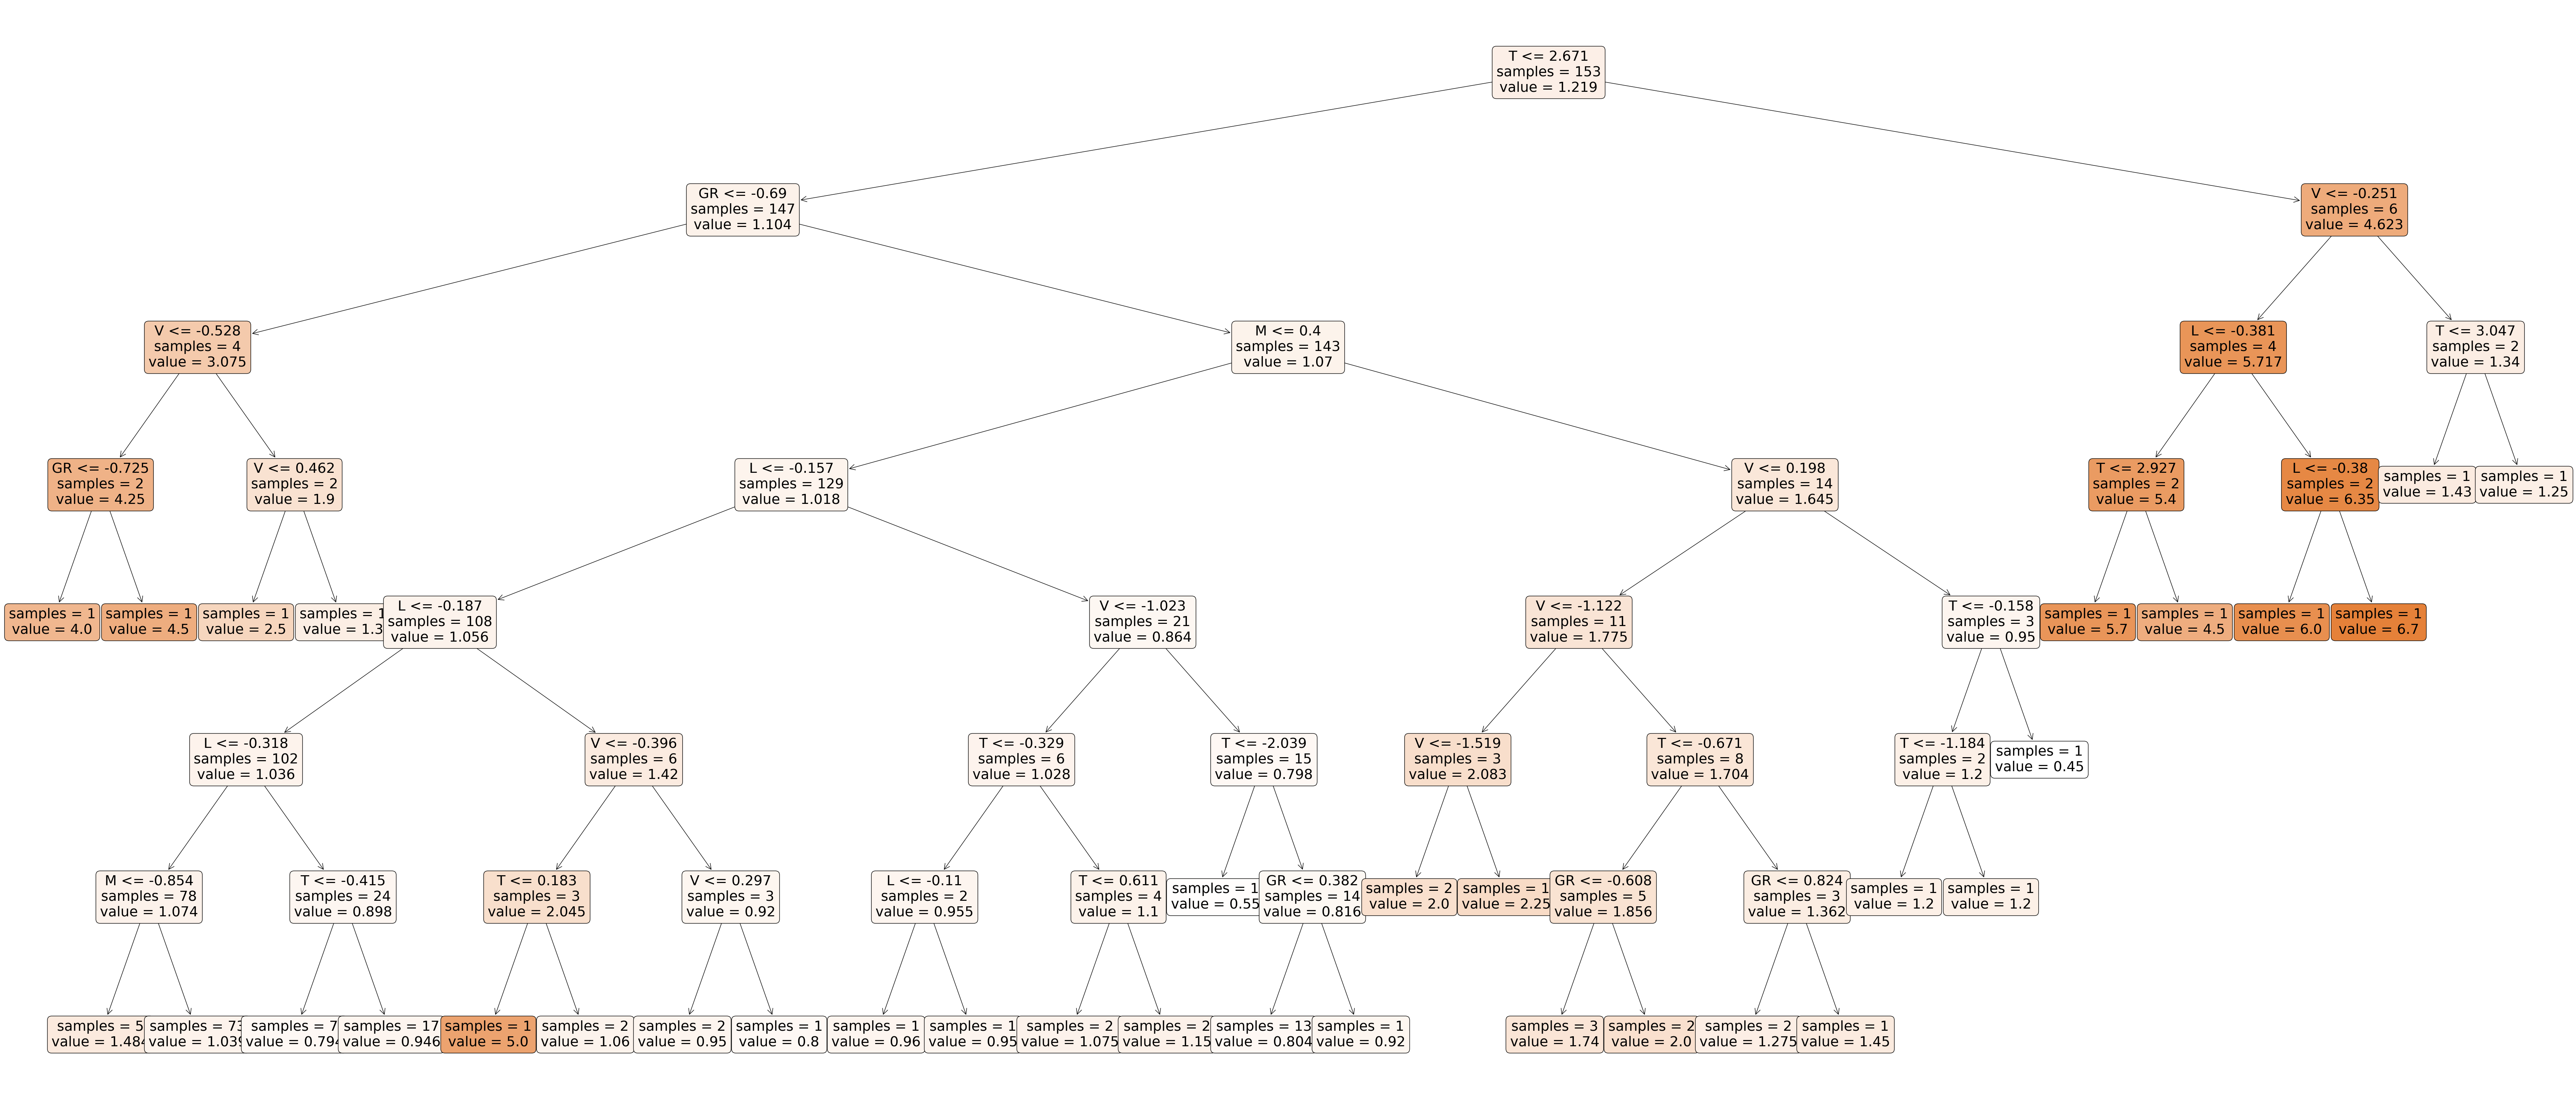

In [14]:
RFR_best = RandomForestRegressor(n_estimators=10, max_depth=7, min_samples_split=2, random_state=0)
RFR_best.fit(X_train, y_train)

y_predict = RFR_best.predict(X_test)
y_predict2 = RFR_best.predict(X_train)

train_score = RFR_best.score(X_train, y_train)
test_score = RFR_best.score(X_test, y_test)
train_mse = mean_squared_error(y_train, y_predict2)
test_mse = mean_squared_error(y_test, y_predict)

fig1 = plt.figure(figsize=(6,5))
plt.scatter(y_train, y_predict2, s=500, c='skyblue', alpha=0.7, label='Train', edgecolors='black')
plt.scatter(y_test, y_predict, s=500, c='orange', label='Test', edgecolors='black')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Actual ρ', size=25)
plt.ylabel('Predicted ρ', size=25)
plt.text(0.1, 4.4, f'Model: RF\nTrain R$^{2}$: {train_score:.2f}\nTrain MSE: {train_mse:.2f}\nTest R$^{2}$: {test_score:.2f}\nTest MSE: {test_mse:.2f}', fontsize=18)
plt.legend(loc=4, fontsize=20, frameon=True)
plt.tick_params(which='both', direction='in', labelsize=15)
plt.tight_layout()
plt.savefig('RFR Actual vs. Predicted.jpg', format='jpeg', dpi=600)
plt.show()


# plot the tree structure
from sklearn.tree import plot_tree

tree = RFR_best.estimators_[4]
plt.figure(figsize=(70,30))
plot_tree(tree, feature_names=features, filled=True, rounded=True, impurity=False, fontsize=27)
plt.tight_layout()
plt.savefig('RFR_tree.jpg', format='jpeg', dpi=300)
plt.show()

Using 244 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/61 [00:00<?, ?it/s]

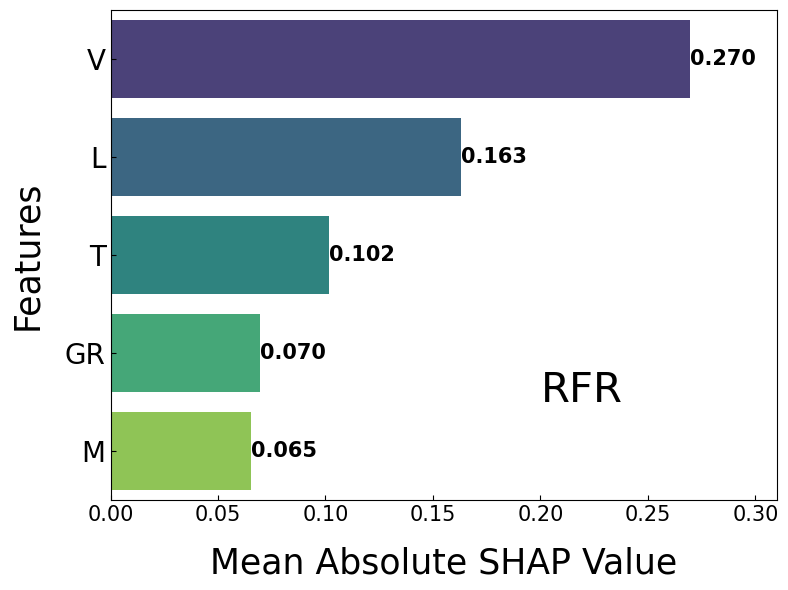

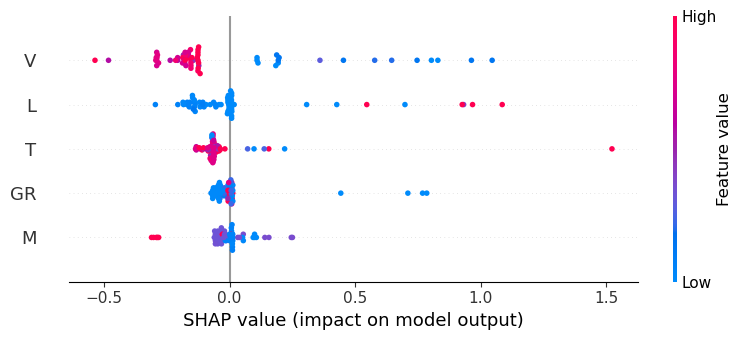

In [16]:
# determine the feature importance
# use SHAP to explain and visualize the feature importance
import shap
shap.initjs()
# Creating the KernelExplainer
RFR_explainer = shap.KernelExplainer(RFR_best.predict, X_train)
RFR_shap_values = RFR_explainer.shap_values(X_test)
# Generating the bar plot with mean SHAP values and feature names
# Calculate mean absolute SHAP values for each feature
mean_abs_shap_values = np.mean(np.abs(RFR_shap_values), axis=0)

# Create a DataFrame for plotting with SHAP values
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': mean_abs_shap_values})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
# Plotting the feature importances with values
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
# Adding the values on the bars
for index, value in enumerate(importance_df['Importance']):
    plt.text(value, index, f'{value:.3f}', va='center', ha='left', color='black', fontweight='bold', fontsize=15)

plt.xlim(0,0.31)
plt.xlabel('Mean Absolute SHAP Value', size=25, labelpad=15)
plt.ylabel('Features', size=25, labelpad=15)
plt.tick_params(axis='x', direction='in', labelsize=15)
plt.tick_params(axis='y', direction='in', labelsize=20)
plt.text(0.2, len(importance_df) - 1.5, 'RFR', fontsize=30)
plt.tight_layout()
plt.savefig('RFR Feature Importance.jpg', format='jpeg', dpi=600)
plt.show()
# Generating the summary plot showing the distribution of SHAP values for each feature
shap.summary_plot(RFR_shap_values, X_test, feature_names=X.columns)